# (28751) Eggl orbit determination test

#### Let's start by importing the necessary libraries

In [1]:
from grss import fit
import numpy as np
np.set_printoptions(precision=40, linewidth=np.inf)

#### We'll then retrieve the cometary state of the asteroid (from JPL SBDB) plus any nongravitational accelerations acting on it.

In [2]:
body_id = '28751'
init_sol, init_cov, nongrav_info = fit.get_sbdb_info(body_id)
de_kernel = 440

#### Next, we'll retrieve the observations from different sources (MPC, JPL, Gaia Data Releases) and prepare them for the orbit determination process.

In [3]:
add_gaia_obs = True
optical_obs_file = None
t_min_tdb = None
t_max_tdb = None
debias_lowres = True
deweight = True
eliminate = False
num_obs_per_night = 4
verbose = True
obs_df = fit.get_optical_obs(body_id, optical_obs_file, t_min_tdb, t_max_tdb, debias_lowres, deweight, eliminate, num_obs_per_night, verbose)
obs_df = fit.add_radar_obs(obs_df, t_min_tdb, t_max_tdb, verbose)
if add_gaia_obs:
    gaia_dr = 'gaiafpr'
    obs_df = fit.add_gaia_obs(obs_df, t_min_tdb, t_max_tdb, gaia_dr, verbose)

Read in 1510 observations from the MPC.
	Filtered to 1510 observations that satisfy the time range and accepted observatory constraints.
Applying Eggl et al. (2020) debiasing scheme to the observations.
	Unknown star catalog: GSC
	Unknown star catalog: UNK
	No debiasing needed for 604 observations.
	Debiased 891 observations.
	No bias information for 15 observations.
Applying Vereš et al. (2017) weighting scheme to the observations.
	Using 1412 CCD observations with station-specific weight rules.
Applying sqrt(N/4) deweighting scheme.
	Deweighted 297 observations.
Read in 273 Gaia observations from gaiafpr
	Filtered to 273 observations that satisfy the time range constraints.


#### All we need to do now is initialize the OD simulation and run the filter.

In [4]:
n_iter_max = 10
fit_sim = fit.FitSimulation(init_sol, obs_df, init_cov, n_iter_max=n_iter_max, de_kernel=de_kernel, nongrav_info=nongrav_info)

In [5]:
fit_sim.filter_lsq()

Iteration		Unweighted RMS		Weighted RMS 		Chi-squared		Reduced Chi-squared
1			 0.381			 0.550			 1078.819			 0.303
2			 0.381			 0.550			 1078.397			 0.303
Converged without rejecting outliers. Starting outlier rejection now...
3			 0.371			 0.533			 1011.850			 0.285
4			 0.371			 0.533			 1011.492			 0.285
Converged after rejecting outliers. Rejected 5 out of 1783 optical observations.


#### Let's print some summary statistics and plot some results.

In [6]:
fit_sim.print_summary()

Summary of the orbit fit calculations after postfit pass:
RMS unweighted: 0.37124363565131496
RMS weighted: 0.5325868969205222
chi-squared: 1011.4916306829228
reduced chi-squared: 0.2849272199106825
square root of reduced chi-squared: 0.5337857434501998
--------------------------------------------------------------
Solution Time: MJD 57925.000 TDB = 2017-06-21 00:00:00.000 TDB
Solution Observation Arc: 10751.92 days (29.44 years)
--------------------------------------------------------------
Fitted Variable		Initial Value			Uncertainty			Fitted Value			Uncertainty			Change				Change (sigma)
e			1.13513023195e-01		2.67007990945e-09		1.13513023699e-01		2.67513861027e-09		+5.03566716104e-10		+0.188
q			2.23466959797e+00		5.18141566983e-09		2.23466959743e+00		5.17869282268e-09		-5.40652855818e-10		-0.104
tp			5.79392660677e+04		3.10261576800e-06		5.79392660677e+04		3.10175869749e-06		+2.32321326621e-08		+0.007
om			2.76276478601e+02		2.72877315675e-06		2.76276478735e+02		2.72847257859e-06	

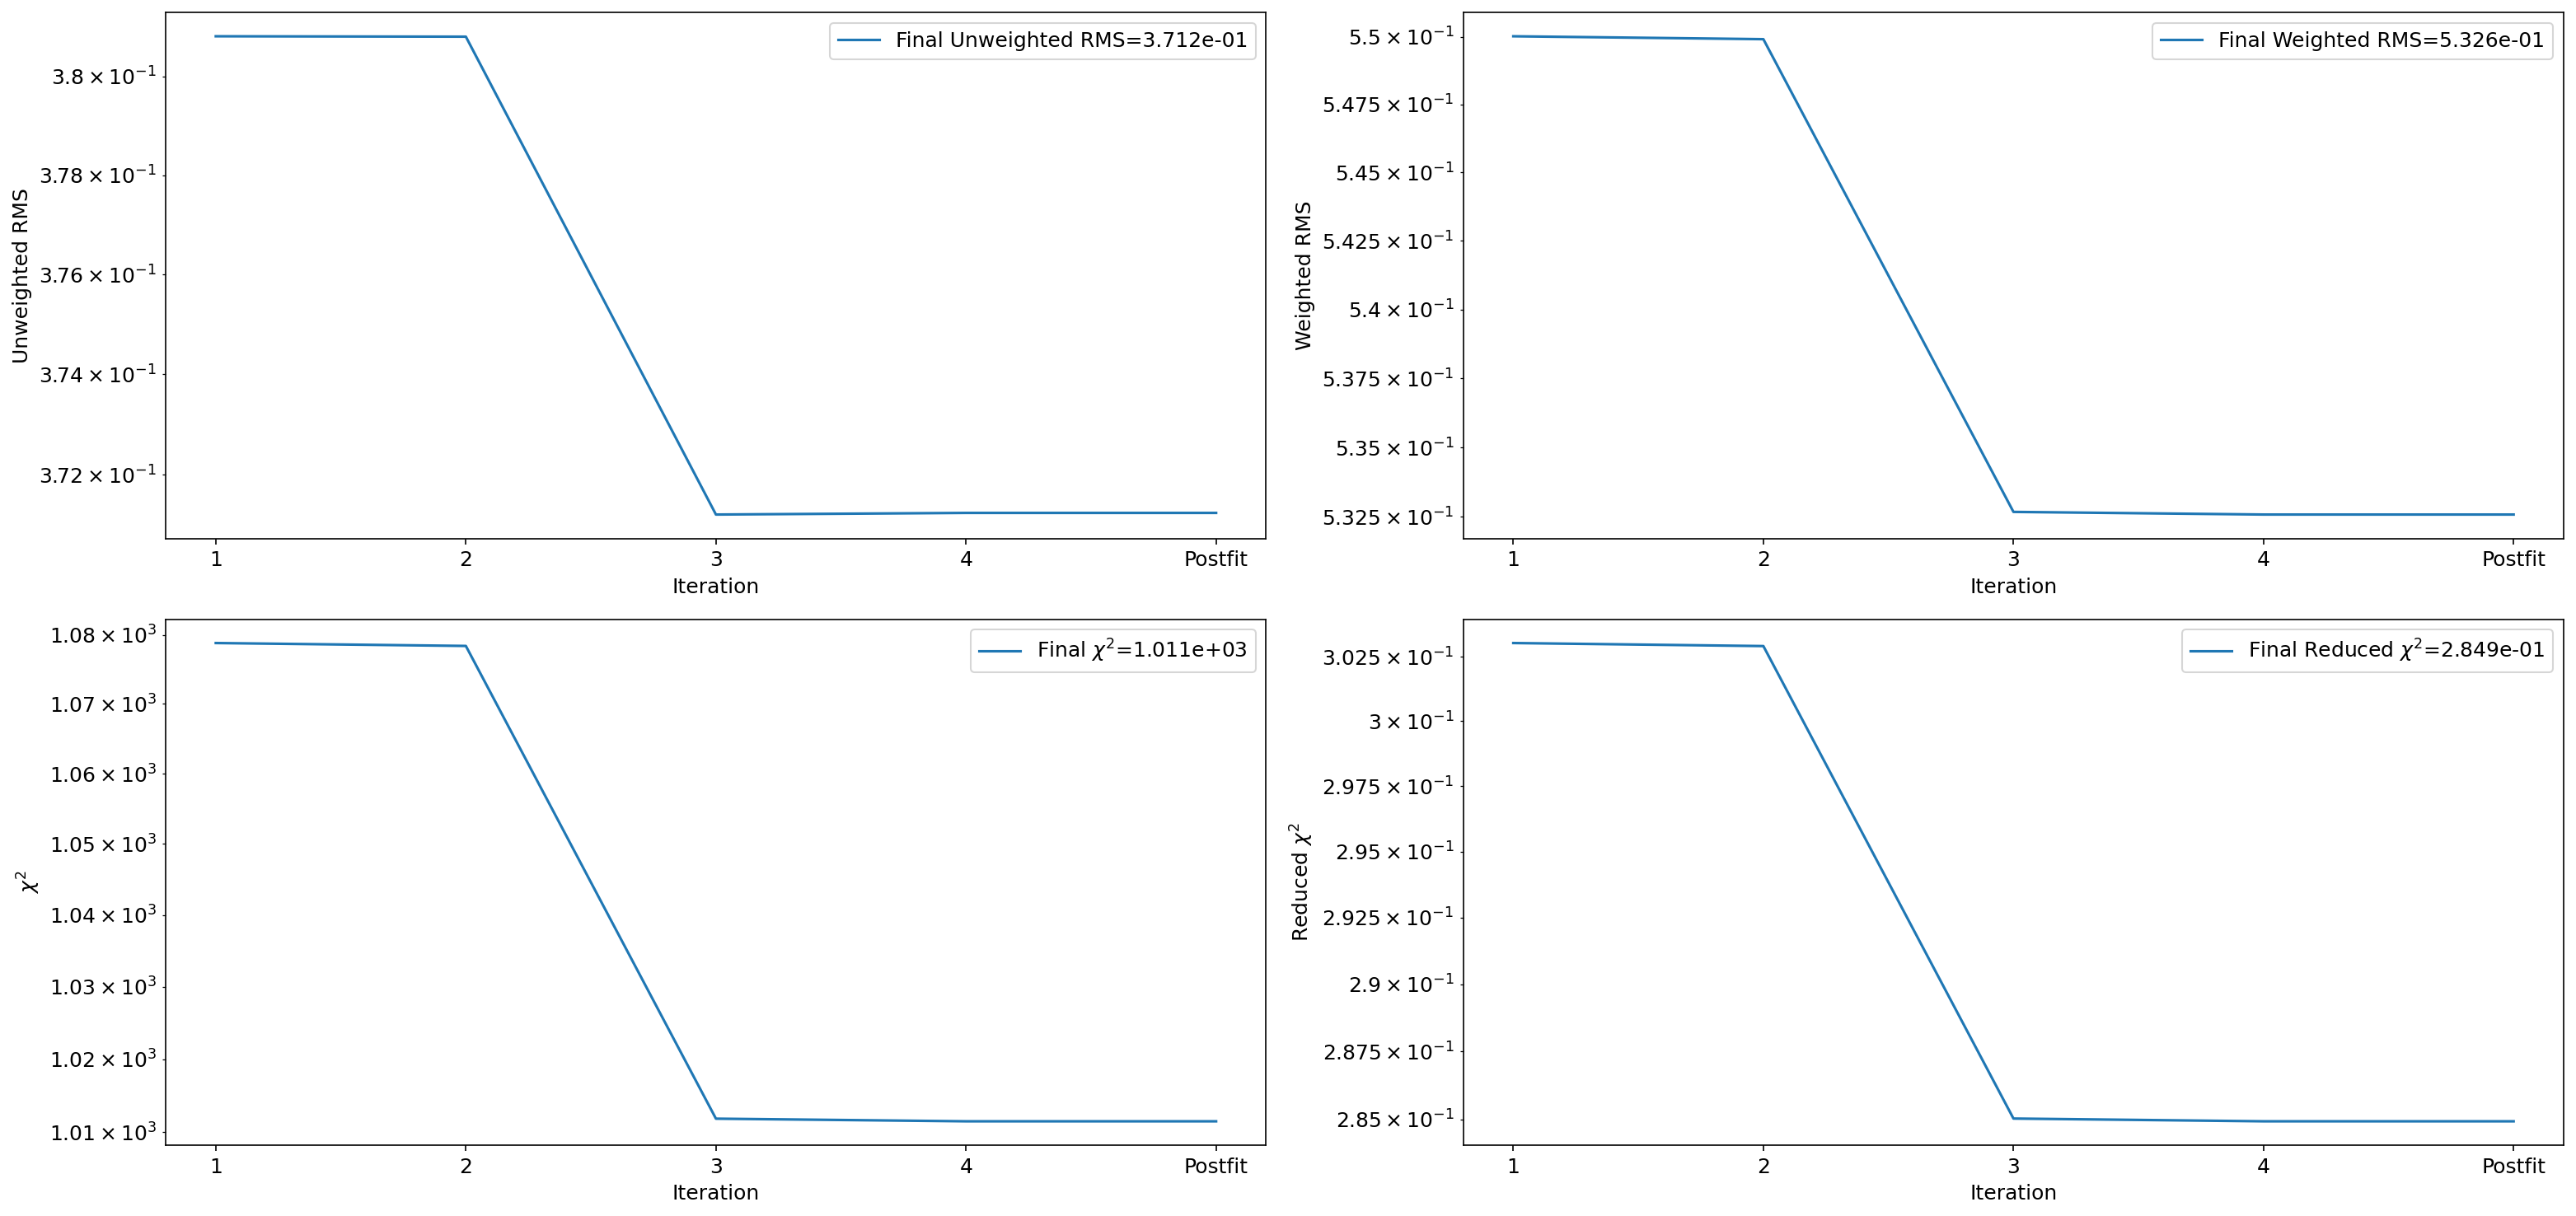

In [7]:
fit_sim.plot_summary(auto_close=True)

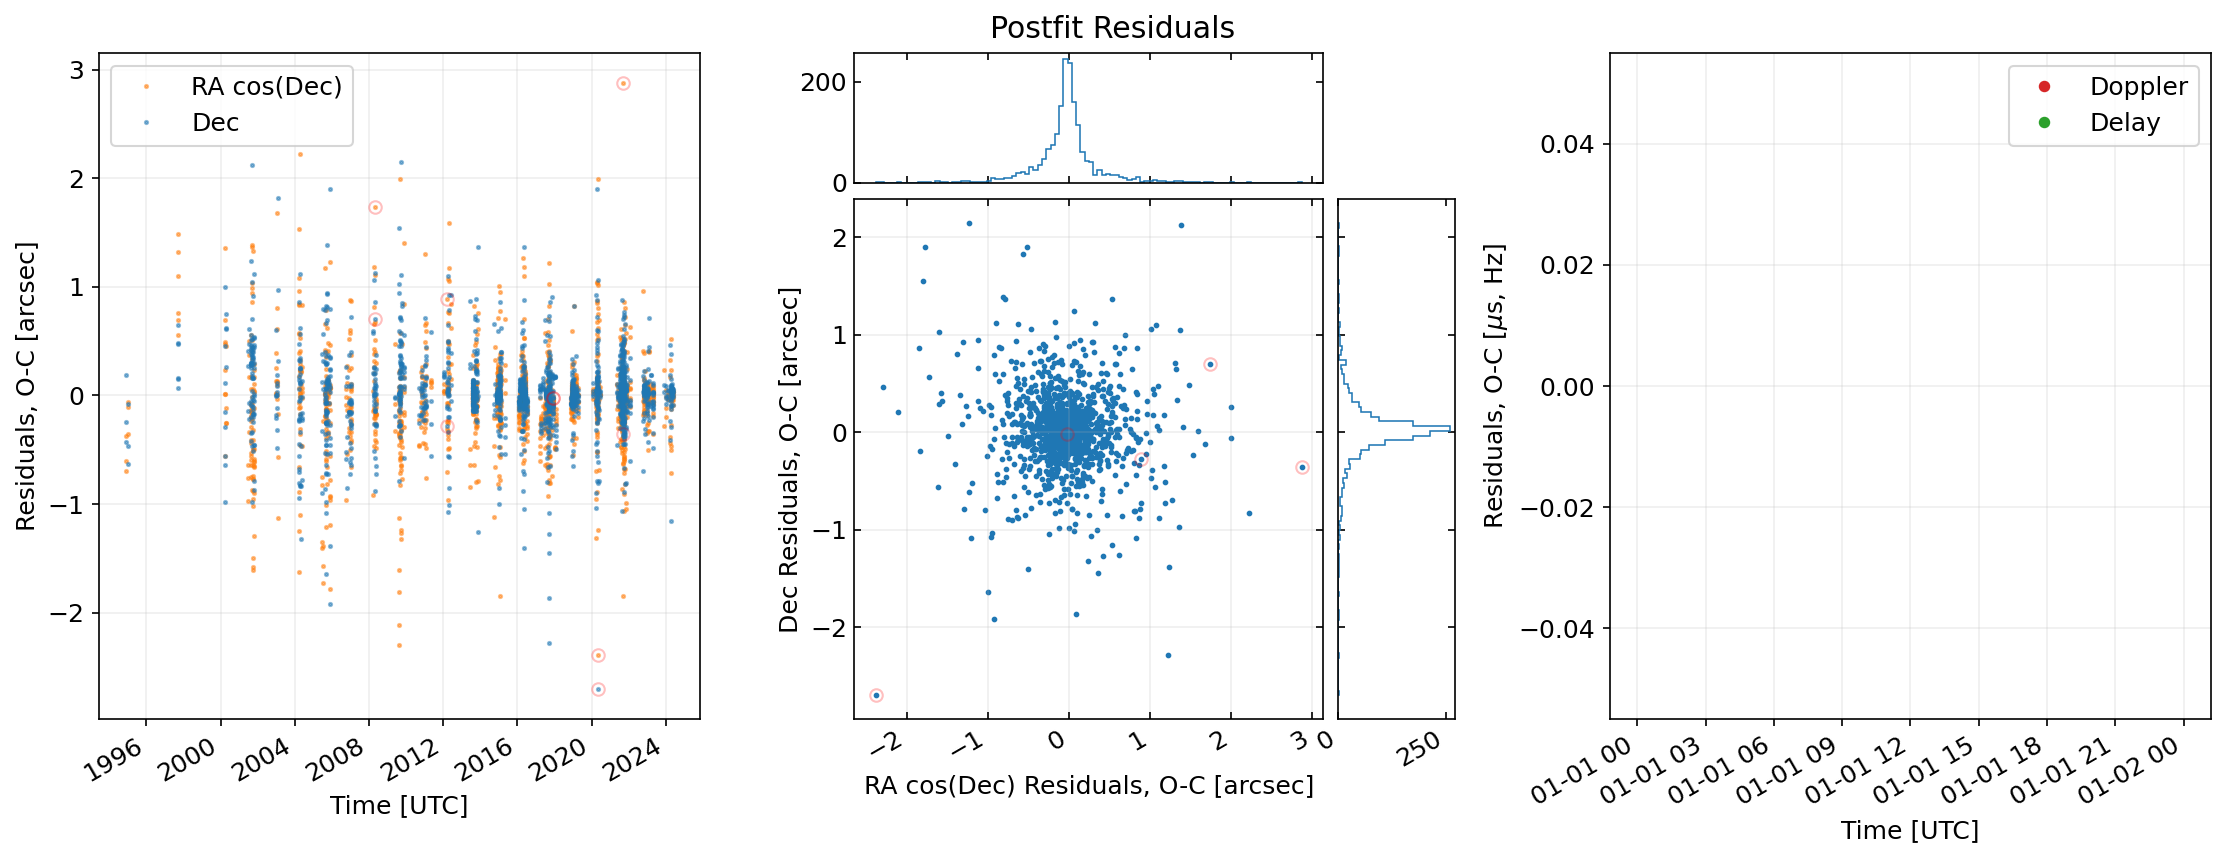

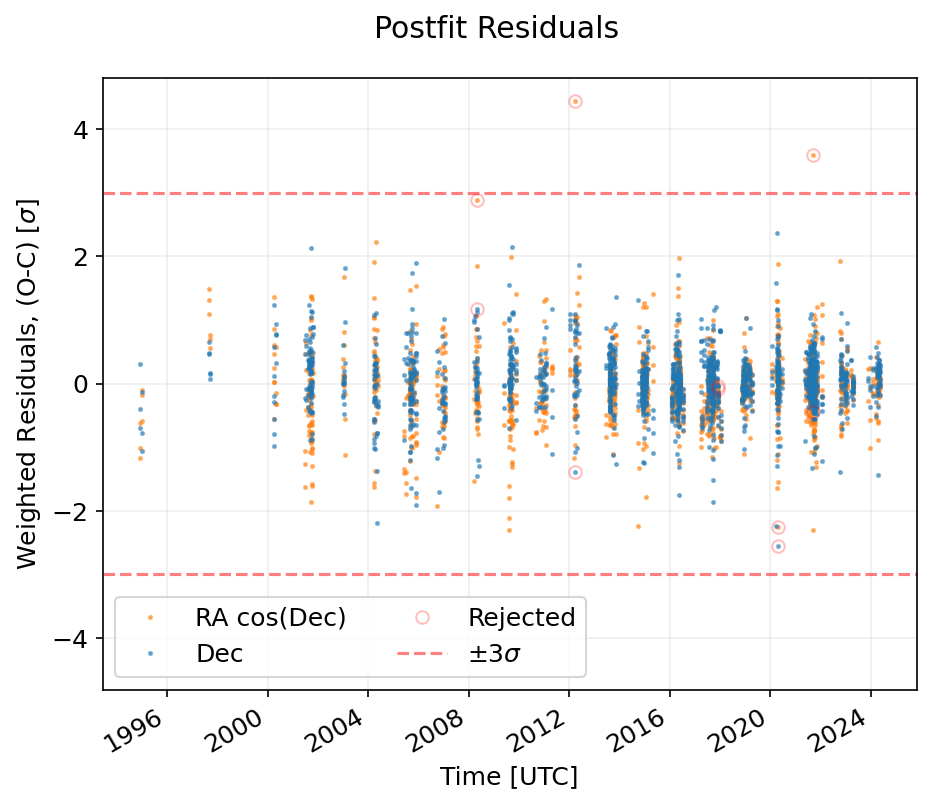

In [8]:
fit_sim.iters[-1].plot_iteration_summary(title='Postfit Residuals', auto_close=True)

In [9]:
mean_0 = np.array(list(init_sol.values())[1:])
cov_0 = init_cov
mean_f = np.array(list(fit_sim.x_nom.values()))
cov_f = fit_sim.covariance

maha_dist_f, maha_dist_0, bhattacharya, bhatt_coeff = fit.get_similarity_stats(mean_0, cov_0, mean_f, cov_f)
print(f'Mahalonobis distance between JPL and GRSS solution: {maha_dist_f:0.2f}')
print(f'Mahalonobis distance between GRSS and JPL solution: {maha_dist_0:0.2f}')
print(f'Bhattacharya distance between JPL and GRSS solution: {bhattacharya:0.4f}')
print(f'Bhattacharya coefficient between JPL and GRSS solution: {bhatt_coeff:0.4f}')

Mahalonobis distance between JPL and GRSS solution: 0.24
Mahalonobis distance between GRSS and JPL solution: 0.24
Bhattacharya distance between JPL and GRSS solution: 0.0000
Bhattacharya coefficient between JPL and GRSS solution: 1.0000


#### Finally, we'll make sure the GRSS solution is statistically consistent with the JPL SBDB solution

In [10]:
assert maha_dist_f < 5.0
assert maha_dist_0 < 5.0
assert bhattacharya < 0.10
assert bhatt_coeff > 0.90